**Using Keras and Shakespeares texts to create text**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Load the data

In [2]:
text = open('./data/shakespeare.txt', 'r').read()

In [3]:
vocabulary = sorted(set(text))

In [4]:
len(vocabulary)

84

In [5]:
char_to_idx = {c:i for i, c in enumerate(vocabulary)}

In [6]:
idx_to_char = np.array(vocabulary)

In [7]:
encoded_text = np.array([char_to_idx[c] for c in text])

In [8]:
encoded_text[:500]

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 12,  0,  1,  1, 31, 73, 70, 68,  1, 61, 56, 64,
       73, 60, 74, 75,  1, 58, 73, 60, 56, 75, 76, 73, 60, 74,  1, 78, 60,
        1, 59, 60, 74, 64, 73, 60,  1, 64, 69, 58, 73, 60, 56, 74, 60,  8,
        0,  1,  1, 45, 63, 56, 75,  1, 75, 63, 60, 73, 60, 57, 80,  1, 57,
       60, 56, 76, 75, 80,  5, 74,  1, 73, 70, 74, 60,  1, 68, 64, 62, 63,
       75,  1, 69, 60, 77, 60, 73,  1, 59, 64, 60,  8,  0,  1,  1, 27, 76,
       75,  1, 56, 74,  1, 75, 63, 60,  1, 73, 64, 71, 60, 73,  1, 74, 63,
       70, 76, 67, 59,  1, 57, 80,  1, 75, 64, 68, 60,  1, 59, 60, 58, 60,
       56, 74, 60,  8,  0,  1,  1, 33, 64, 74,  1, 75, 60, 69, 59, 60, 73,
        1, 63, 60, 64, 73,  1, 68, 64, 62, 63, 75,  1, 57, 60, 56, 73,  1,
       63, 64, 74,  1, 68, 60, 68, 70, 73, 80, 21,  0,  1,  1, 27, 76, 75,
        1, 75, 63, 70, 76,  1, 58, 70, 69, 75, 73, 56, 58, 75, 60, 59,  1,
       75, 70,  1, 75, 63

In [9]:
lines_of_text = text.split('\n')
lengths_of_lines = [len(i) for i in lines_of_text if len(i)>0]

Find the length of the each line

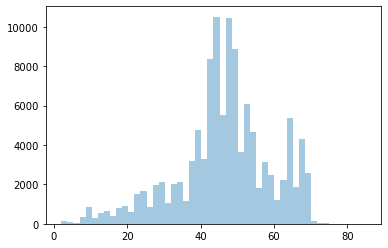

In [10]:
sns.distplot(lengths_of_lines, kde=False)
plt.show()

In [11]:
np.mean(lengths_of_lines), np.median(lengths_of_lines)

(46.365524692433695, 47.0)

In [12]:
seq_len = 120
total_num_seq = len(text) // (seq_len+1)

In [13]:
total_num_seq

45005

In [14]:
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

In [15]:
print(text[:100])


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose mi


In [16]:
for i in char_dataset.take(100):
    print(idx_to_char[i.numpy()], end='')


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose mi

In [17]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

In [18]:
def create_seq_targets(seq):
    # input_text = seq[:-1]
    # target_text = seq[1:]
    return seq[:-1], seq[1:]

In [19]:
dataset = sequences.map(create_seq_targets)

In [20]:
for input_text, target_text in dataset.take(1):
    print(input_text.numpy())
    print("".join(idx_to_char[input_text.numpy()]))
    print('---')
    print(target_text.numpy())
    print("".join(idx_to_char[target_text.numpy()]))


[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0
  1  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74
  1 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45
 63 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74
 60  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75]

                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But
---
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0  1
  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74  1
 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45 63
 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74 60
  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75  1]
                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But 


In [21]:
batch_size = 128

In [22]:
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [23]:
for input_text, target_text in dataset.take(1):
    print(input_text.numpy()[0])
    print("".join(idx_to_char[input_text.numpy()[0]]))
    print('---')
    print(target_text.numpy()[0])
    print("".join(idx_to_char[target_text.numpy()[0]]))


[ 1 34  1 73 60 58 70 77 60 73  5 59  1 63 64 68  8  1 57 70 76 69 59  1
 76 71  1 63 64 74  1 78 70 76 69 59  8  0  1  1  1  1 26 69 59  8  1 56
 61 75 60 73  1 74 70 68 60  1 74 68 56 67 67  1 74 71 56 58 60  8  1 57
 60 64 69 62  1 74 75 73 70 69 62  1 56 75  1 63 60 56 73 75  8  0  1  1
  1  1 33 60  1 74 60 69 75  1 68 60  1 63 64 75 63 60 73  8  1 74 75 73]
 I recover'd him, bound up his wound,
    And, after some small space, being strong at heart,
    He sent me hither, str
---
[34  1 73 60 58 70 77 60 73  5 59  1 63 64 68  8  1 57 70 76 69 59  1 76
 71  1 63 64 74  1 78 70 76 69 59  8  0  1  1  1  1 26 69 59  8  1 56 61
 75 60 73  1 74 70 68 60  1 74 68 56 67 67  1 74 71 56 58 60  8  1 57 60
 64 69 62  1 74 75 73 70 69 62  1 56 75  1 63 60 56 73 75  8  0  1  1  1
  1 33 60  1 74 60 69 75  1 68 60  1 63 64 75 63 60 73  8  1 74 75 73 56]
I recover'd him, bound up his wound,
    And, after some small space, being strong at heart,
    He sent me hither, stra


In [24]:
embed_dimensions = 64
rnn_neurons = 1026
vocabulary_size = len(vocabulary)

In [25]:
def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

In [26]:
def create_model(vocab_size, embed_dim, rnn_neurons, batch_size):

    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim,
                        batch_input_shape=[batch_size, None]))

    model.add(GRU(rnn_neurons, return_sequences=True, stateful=True,
                  recurrent_initializer='glorot_uniform'))

    model.add(Dense(vocab_size))

    model.compile(optimizer='adam', loss=sparse_cat_loss)
    return model

In [27]:
model = create_model(vocab_size=vocabulary_size,
                     embed_dim=embed_dimensions,
                     rnn_neurons=rnn_neurons,
                     batch_size=batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 64)           5376      
_________________________________________________________________
gru (GRU)                    (128, None, 1026)         3361176   
_________________________________________________________________
dense (Dense)                (128, None, 84)           86268     
Total params: 3,452,820
Trainable params: 3,452,820
Non-trainable params: 0
_________________________________________________________________


In [28]:
epochs = 30
# with tf.device('/device:gpu:0'):
model.fit(dataset, epochs=epochs)

Epoch 1/30
 25/351 [=>............................] - ETA: 23s - loss: 4.2514

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Adam/Adam/update/AssignSubVariableOp/_27}}]]
	 [[gradient_tape/sequential/embedding/embedding_lookup/Reshape/_24]] [Op:__inference_train_function_2598]

Function call stack:
train_function


Print some predicted text before training the model

In [ ]:
# for input_example_batch, target_example_batch in dataset.take(1):
#     example_batch_pred = model(input_example_batch)